# Spatial Context Calculation


### Results Summary
It is shown that the models trained on the whole image without spatial context, have no considerable improvement in performance when MAE is calculated using different Spatial context. 

Contrary to the expected behaviour, the models that forecast for the longest time horizons have more benefit on using a smaller spatial context, 128 pixels, while the shortes time horizons benefit on a spatial context of 256 pixels.

Although this experiment might show results that could differ from the expected behaviour when training new models using the spatial context, it is decided to use a spatial context of 256 pixels. This means that the model inputs images with size 1024 x 1024 and outpus 512 x 512 images.


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import matplotlib.pyplot as plt
import visualization as viz
from models import DeterministicUNet, UNetConfig
from metrics.deterministic_metrics import relative_rmse, relative_mae
import numpy as np
import random
from tqdm import tqdm


In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"using device: {device}")


using device: cuda


# Load Checkpoints


In [5]:
unet_det_10min = "../checkpoints/goes16/det_10min/det/UNet_IN3_F16_SC0_BS_6_TH10_E20_BVM0_03_D2024-10-20_04:06.pt"
unet_det_60min = "../checkpoints/goes16/det32_60min/det/UNet_IN3_F32_SC0_BS_4_TH60_E5_BVM0_05_D2024-10-19_08:05.pt"
unet_det_120min = "../checkpoints/goes16/det32_120min/det/UNet_IN3_F32_SC0_BS_4_TH120_E7_BVM0_07_D2024-10-24_11:54.pt"
unet_det_180min = "../checkpoints/goes16/det32_180min/det/UNet_IN3_F32_SC0_BS_4_TH180_E20_BVM0_08_D2024-10-25_03:40.pt"
unet_det_240min = "../checkpoints/goes16/det32_240min/det/UNet_IN3_F32_SC0_BS_4_TH240_E15_BVM0_09_D2024-10-29_16:37.pt"
unet_det_300min = "../checkpoints/goes16/det32_300min/det/UNet_IN3_F32_SC0_BS_4_TH300_E13_BVM0_10_D2024-10-28_21:28.pt"

unet_config = UNetConfig(
    in_frames=3,
    spatial_context=0,
    filters=16,
    output_activation="sigmoid",
    device=device,
)


# Run on validation to calculate Spatial context

## 10 minutes

In [8]:
probabilistic_unet = DeterministicUNet(config=unet_config)

probabilistic_unet.load_checkpoint(checkpoint_path=unet_det_10min, device=device)
probabilistic_unet.model.eval()
probabilistic_unet.create_dataloaders(
    dataset="goes16",
    path="../datasets/goes16/salto/",
    batch_size=1,
    time_horizon=10,
)

error_img_10 = torch.zeros((1, 1, 1024, 1024)).to(device)

with torch.no_grad():
    for val_batch_idx, (in_frames, out_frames) in enumerate(
        probabilistic_unet.val_loader
    ):

        in_frames = in_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)
        out_frames = out_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)

        with torch.autocast(device_type="cuda", dtype=probabilistic_unet.torch_dtype):
            frames_pred = probabilistic_unet.model(in_frames)
            error_img_10 += torch.abs(frames_pred - out_frames)

error_img_10 = error_img_10 / len(probabilistic_unet.val_loader)


INFO:GOES16Dataset:Number of sequences filtered: 485
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:GOES16Dataset:Number of sequences filtered: 160
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:DeterministicUNet:Train loader size: 25810
INFO:DeterministicUNet:Val loader size: 5203
INFO:DeterministicUNet:Samples height: 1024, Samples width: 1024


min- max errors: 0.021887943148612976 - 0.09084369242191315


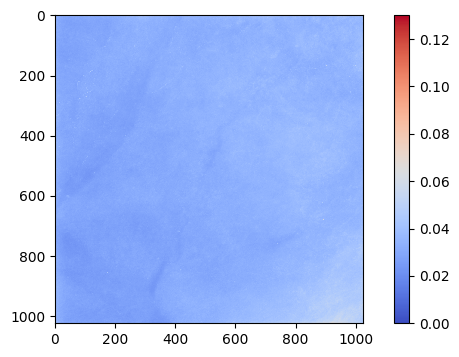

[array(0.03261688, dtype=float32), array(0.0323613, dtype=float32), array(0.03219189, dtype=float32), array(0.03211419, dtype=float32), array(0.03230751, dtype=float32), array(0.03214259, dtype=float32)]


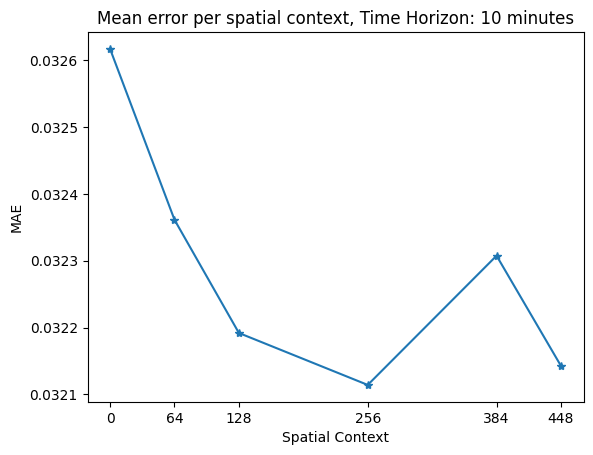

In [25]:
print(f"min- max errors: {error_img_10.min()} - {error_img_10.max()}")

viz.show_image_w_colorbar(
    image=error_img_10.cpu().numpy()[0, 0],
    title=None,
    fig_name="Error Map",
    save_fig=False,
    bar_max=0.13,
    colormap="coolwarm"
)

# mean error against spatial context

spatial_context = [0, 64, 128, 256, 384, 448]
error_per_sc_10 = []
for sc in spatial_context:
    if sc != 0:
        cropped_error_map = error_img_10[0, 0, sc: -sc]
    else:
        cropped_error_map = error_img_10[0, 0]
    error_per_sc_10.append(torch.mean(cropped_error_map).cpu().numpy())

print(error_per_sc_10)

fig, ax = plt.subplots()
plt.plot(spatial_context, error_per_sc_10, "*-")
ax.set_title("Mean error per spatial context, Time Horizon: 10 minutes")
ax.set_ylabel("MAE")
ax.set_xlabel("Spatial Context")
ax.set_xticks(spatial_context)
ax.set_xticklabels(spatial_context)
plt.show()


In [28]:
# improvement with 256 spatial context
improvement_10 = (error_per_sc_10[0] - error_per_sc_10[3])/error_per_sc_10[0] * 100
print(f"Improvement: {improvement_10:.2f}%")


Improvement: 1.54%


## 60 minutes

In [10]:
unet_config = UNetConfig(
    in_frames=3,
    spatial_context=0,
    filters=16,
    output_activation="sigmoid",
    device=device,
)

probabilistic_unet = DeterministicUNet(config=unet_config)

probabilistic_unet.load_checkpoint(checkpoint_path=unet_det_60min, device=device)
probabilistic_unet.model.eval()
probabilistic_unet.create_dataloaders(
    dataset="goes16",
    path="../datasets/goes16/salto/",
    batch_size=1,
    time_horizon=60,
)

error_img_60 = torch.zeros((1, 1, 1024, 1024)).to(device)

with torch.no_grad():
    for val_batch_idx, (in_frames, out_frames) in enumerate(
        probabilistic_unet.val_loader
    ):

        in_frames = in_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)
        out_frames = out_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)

        with torch.autocast(device_type="cuda", dtype=probabilistic_unet.torch_dtype):
            frames_pred = probabilistic_unet.model(in_frames)
            error_img_60 += torch.abs(frames_pred - out_frames)

error_img_60 = error_img_60 / len(probabilistic_unet.val_loader)


INFO:GOES16Dataset:Number of sequences filtered: 614
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:GOES16Dataset:Number of sequences filtered: 192
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:DeterministicUNet:Train loader size: 23247
INFO:DeterministicUNet:Val loader size: 4666
INFO:DeterministicUNet:Samples height: 1024, Samples width: 1024


min- max errors: 0.0411209911108017 - 0.12554830312728882


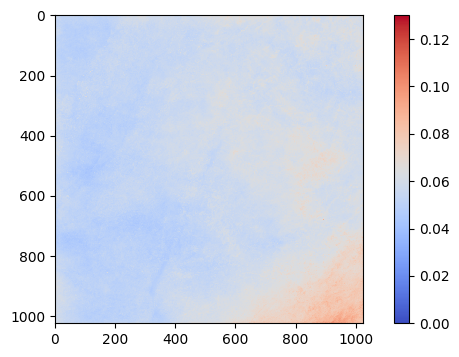

[array(0.05748361, dtype=float32), array(0.05695798, dtype=float32), array(0.05662137, dtype=float32), array(0.05649959, dtype=float32), array(0.05717622, dtype=float32), array(0.05721307, dtype=float32)]


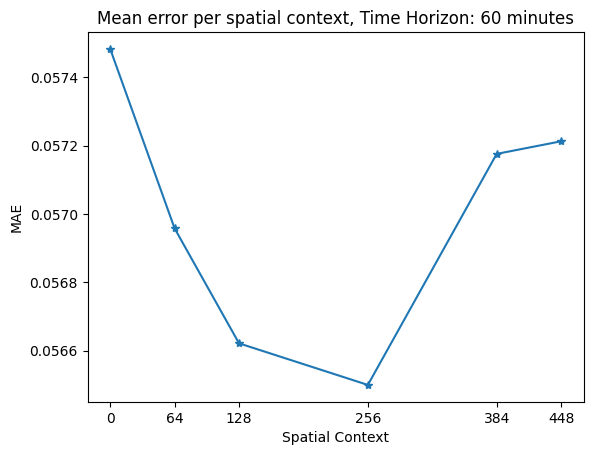

In [24]:
print(f"min- max errors: {error_img_60.min()} - {error_img_60.max()}")

viz.show_image_w_colorbar(
    image=error_img_60.cpu().numpy()[0, 0],
    title=None,
    fig_name="Error Map",
    save_fig=False,
    bar_max=0.13,
    colormap="coolwarm"
)

# mean error against spatial context

spatial_context = [0, 64, 128, 256, 384, 448]
error_per_sc_60 = []
for sc in spatial_context:
    if sc != 0:
        cropped_error_map = error_img_60[0, 0, sc: -sc]
    else:
        cropped_error_map = error_img_60[0, 0]
    error_per_sc_60.append(torch.mean(cropped_error_map).cpu().numpy())

print(error_per_sc_60)

fig, ax = plt.subplots()
plt.plot(spatial_context, error_per_sc_60, "*-")
ax.set_title("Mean error per spatial context, Time Horizon: 60 minutes")
ax.set_ylabel("MAE")
ax.set_xlabel("Spatial Context")
ax.set_xticks(spatial_context)
ax.set_xticklabels(spatial_context)
plt.show()


In [29]:
# improvement with 256 spatial context
improvement_60 = (error_per_sc_60[0] - error_per_sc_60[3])/error_per_sc_60[0] * 100
print(f"Improvement: {improvement_60:.2f}%")


Improvement: 1.71%


## 120 min horizon

In [12]:
probabilistic_unet = DeterministicUNet(config=unet_config)

probabilistic_unet.load_checkpoint(checkpoint_path=unet_det_120min, device=device)
probabilistic_unet.model.eval()
probabilistic_unet.create_dataloaders(
    dataset="goes16",
    path="../datasets/goes16/salto/",
    batch_size=1,
    time_horizon=120,
)

error_img_120 = torch.zeros((1, 1, 1024, 1024)).to(device)

with torch.no_grad():
    for val_batch_idx, (in_frames, out_frames) in enumerate(
        probabilistic_unet.val_loader
    ):

        in_frames = in_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)
        out_frames = out_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)

        with torch.autocast(device_type="cuda", dtype=probabilistic_unet.torch_dtype):
            frames_pred = probabilistic_unet.model(in_frames)
            error_img_120 += torch.abs(frames_pred - out_frames)

error_img_120 = error_img_120 / len(probabilistic_unet.val_loader)


INFO:GOES16Dataset:Number of sequences filtered: 708
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:GOES16Dataset:Number of sequences filtered: 231
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:DeterministicUNet:Train loader size: 20279
INFO:DeterministicUNet:Val loader size: 4024
INFO:DeterministicUNet:Samples height: 1024, Samples width: 1024


min- max errors: 0.05556851997971535 - 0.13540570437908173


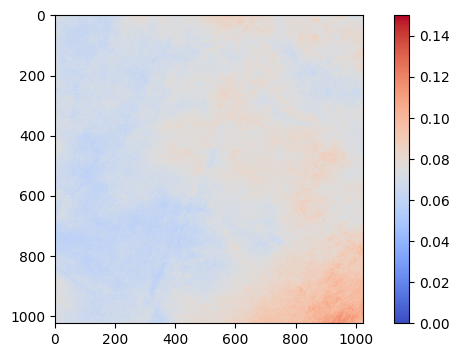

[array(0.07317366, dtype=float32), array(0.07246222, dtype=float32), array(0.07199986, dtype=float32), array(0.07198127, dtype=float32), array(0.07301317, dtype=float32), array(0.07349782, dtype=float32)]


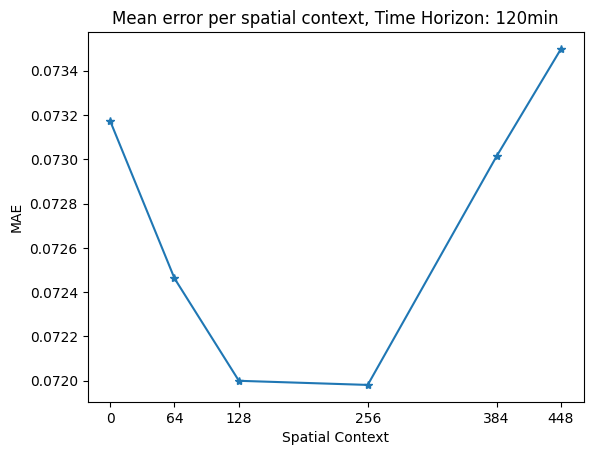

In [22]:
print(f"min- max errors: {error_img_120.min()} - {error_img_120.max()}")

viz.show_image_w_colorbar(
    image=error_img_120.cpu().numpy()[0, 0],
    title=None,
    fig_name="Error Map",
    save_fig=False,
    bar_max=0.15,
    colormap="coolwarm"
)

# mean error against spatial context

spatial_context = [0, 64, 128, 256, 384, 448]
error_per_sc_120 = []
for sc in spatial_context:
    if sc != 0:
        cropped_error_map = error_img_120[0, 0, sc: -sc]
    else:
        cropped_error_map = error_img_120[0, 0]
    error_per_sc_120.append(torch.mean(cropped_error_map).cpu().numpy())

print(error_per_sc_120)

fig, ax = plt.subplots()
plt.plot(spatial_context, error_per_sc_120, "*-")
ax.set_title("Mean error per spatial context, Time Horizon: 120min")
ax.set_ylabel("MAE")
ax.set_xlabel("Spatial Context")
ax.set_xticks(spatial_context)
ax.set_xticklabels(spatial_context)
plt.show()


In [30]:
# improvement with 256 spatial context
improvement_120 = (error_per_sc_120[0] - error_per_sc_120[3])/error_per_sc_120[0] * 100
print(f"Improvement: {improvement_120:.2f}%")


Improvement: 1.63%


## 180 min

In [14]:
probabilistic_unet = DeterministicUNet(config=unet_config)

probabilistic_unet.load_checkpoint(checkpoint_path=unet_det_180min, device=device)
probabilistic_unet.model.eval()
probabilistic_unet.create_dataloaders(
    dataset="goes16",
    path="../datasets/goes16/salto/",
    batch_size=1,
    time_horizon=180,
)

error_img_180 = torch.zeros((1, 1, 1024, 1024)).to(device)

with torch.no_grad():
    for val_batch_idx, (in_frames, out_frames) in enumerate(
        probabilistic_unet.val_loader
    ):

        in_frames = in_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)
        out_frames = out_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)

        with torch.autocast(device_type="cuda", dtype=probabilistic_unet.torch_dtype):
            frames_pred = probabilistic_unet.model(in_frames)
            error_img_180 += torch.abs(frames_pred - out_frames)

error_img_180 = error_img_180 / len(probabilistic_unet.val_loader)


INFO:GOES16Dataset:Number of sequences filtered: 715
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:GOES16Dataset:Number of sequences filtered: 251
INFO:GOES16Dataset:Number of sequences filtered by black images: 0
INFO:DeterministicUNet:Train loader size: 17403
INFO:DeterministicUNet:Val loader size: 3409
INFO:DeterministicUNet:Samples height: 1024, Samples width: 1024


min- max errors: 0.061961494386196136 - 0.13490696251392365


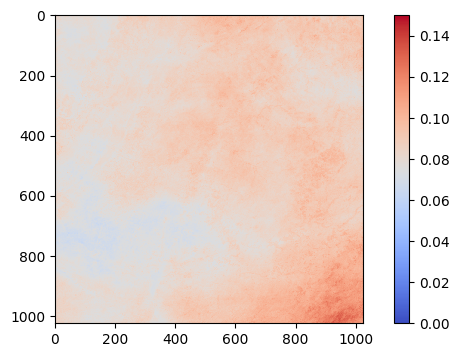

[array(0.0854564, dtype=float32), array(0.08465146, dtype=float32), array(0.08408871, dtype=float32), array(0.08407521, dtype=float32), array(0.08551816, dtype=float32), array(0.08601976, dtype=float32)]


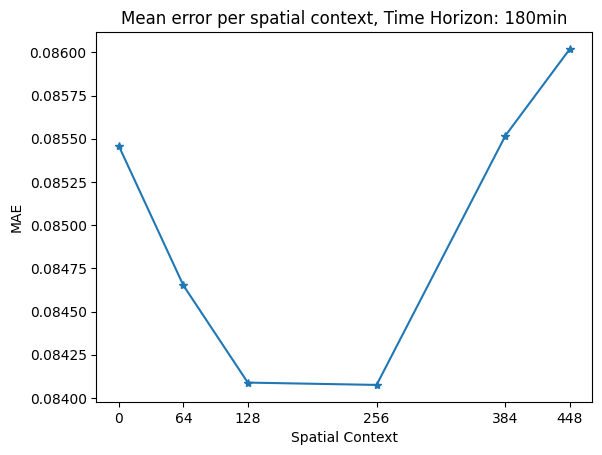

In [26]:
print(f"min- max errors: {error_img_180.min()} - {error_img_180.max()}")

viz.show_image_w_colorbar(
    image=error_img_180.cpu().numpy()[0, 0],
    title=None,
    fig_name="Error Map",
    save_fig=False,
    bar_max=0.15,
    colormap="coolwarm"
)


# mean error against spatial context

spatial_context = [0, 64, 128, 256, 384, 448]
error_per_sc_180 = []
for sc in spatial_context:
    if sc != 0:
        cropped_error_map = error_img_180[0, 0, sc: -sc]
    else:
        cropped_error_map = error_img_180[0, 0]
    error_per_sc_180.append(torch.mean(cropped_error_map).cpu().numpy())

print(error_per_sc_180)

fig, ax = plt.subplots()
plt.plot(spatial_context, error_per_sc_180, "*-")
ax.set_title("Mean error per spatial context, Time Horizon: 180min")
ax.set_ylabel("MAE")
ax.set_xlabel("Spatial Context")
ax.set_xticks(spatial_context)
ax.set_xticklabels(spatial_context)
plt.show()


In [31]:
# improvement with 256 spatial context
improvement_180 = (error_per_sc_180[0] - error_per_sc_180[3])/error_per_sc_180[0] * 100
print(f"Improvement: {improvement_180:.2f}%")


Improvement: 1.62%


## 240 min

In [6]:
probabilistic_unet = DeterministicUNet(config=unet_config)

probabilistic_unet.load_checkpoint(checkpoint_path=unet_det_240min, device=device)
probabilistic_unet.model.eval()
probabilistic_unet.create_dataloaders(
    dataset="goes16",
    path="../datasets/goes16/salto/",
    batch_size=1,
    time_horizon=240,
)

error_img_240 = torch.zeros((1, 1, 1024, 1024)).to(device)

with torch.no_grad():
    for val_batch_idx, (in_frames, out_frames) in enumerate(
        probabilistic_unet.val_loader
    ):

        in_frames = in_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)
        out_frames = out_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)

        with torch.autocast(device_type="cuda", dtype=probabilistic_unet.torch_dtype):
            frames_pred = probabilistic_unet.model(in_frames)
            error_img_240 += torch.abs(frames_pred - out_frames)

error_img_240 = error_img_240 / len(probabilistic_unet.val_loader)


INFO:GOES16Dataset:Number of sequences filtered: 664
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:GOES16Dataset:Number of sequences filtered: 231
INFO:GOES16Dataset:Number of sequences filtered by black images: 0
INFO:DeterministicUNet:Train loader size: 14614
INFO:DeterministicUNet:Val loader size: 2840
INFO:DeterministicUNet:Samples height: 1024, Samples width: 1024


min- max errors: 0.06669019162654877 - 0.15490078926086426


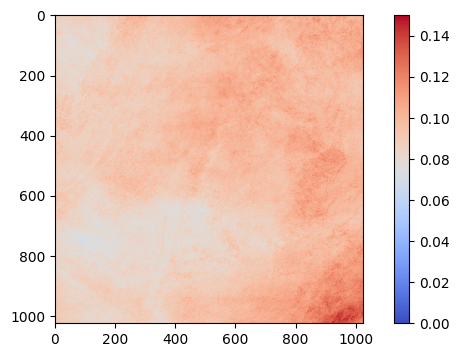

[array(0.09449247, dtype=float32), array(0.09379283, dtype=float32), array(0.09342635, dtype=float32), array(0.09376983, dtype=float32), array(0.09572504, dtype=float32), array(0.09662179, dtype=float32)]


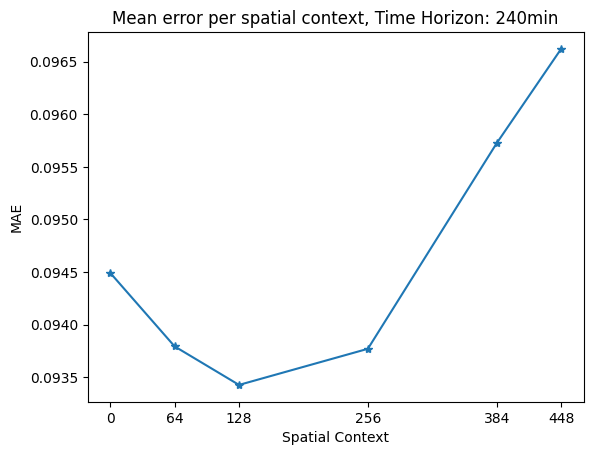

In [7]:
print(f"min- max errors: {error_img_240.min()} - {error_img_240.max()}")

viz.show_image_w_colorbar(
    image=error_img_240.cpu().numpy()[0, 0],
    title=None,
    fig_name="Error Map",
    save_fig=False,
    bar_max=0.16,
    colormap="coolwarm"
)


# mean error against spatial context

spatial_context = [0, 64, 128, 256, 384, 448]
error_per_sc_240 = []
for sc in spatial_context:
    if sc != 0:
        cropped_error_map = error_img_240[0, 0, sc: -sc]
    else:
        cropped_error_map = error_img_240[0, 0]
    error_per_sc_240.append(torch.mean(cropped_error_map).cpu().numpy())

print(error_per_sc_240)

fig, ax = plt.subplots()
plt.plot(spatial_context, error_per_sc_240, "*-")
ax.set_title("Mean error per spatial context, Time Horizon: 240min")
ax.set_ylabel("MAE")
ax.set_xlabel("Spatial Context")
ax.set_xticks(spatial_context)
ax.set_xticklabels(spatial_context)
plt.show()


In [8]:
# improvement with 256 spatial context
improvement_240 = (error_per_sc_240[0] - error_per_sc_240[3])/error_per_sc_240[0] * 100
print(f"Improvement: {improvement_240:.2f}%")


Improvement: 0.76%


## 300 min

In [9]:
probabilistic_unet = DeterministicUNet(config=unet_config)

probabilistic_unet.load_checkpoint(checkpoint_path=unet_det_300min, device=device)
probabilistic_unet.model.eval()
probabilistic_unet.create_dataloaders(
    dataset="goes16",
    path="../datasets/goes16/salto/",
    batch_size=1,
    time_horizon=300,
)

error_img_300 = torch.zeros((1, 1, 1024, 1024)).to(device)

with torch.no_grad():
    for val_batch_idx, (in_frames, out_frames) in enumerate(
        probabilistic_unet.val_loader
    ):

        in_frames = in_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)
        out_frames = out_frames.to(device=device, dtype=probabilistic_unet.torch_dtype)

        with torch.autocast(device_type="cuda", dtype=probabilistic_unet.torch_dtype):
            frames_pred = probabilistic_unet.model(in_frames)
            error_img_300 += torch.abs(frames_pred - out_frames)

error_img_300 = error_img_300 / len(probabilistic_unet.val_loader)


INFO:GOES16Dataset:Number of sequences filtered: 491
INFO:GOES16Dataset:Number of sequences filtered by black images: 1
INFO:GOES16Dataset:Number of sequences filtered: 163
INFO:GOES16Dataset:Number of sequences filtered by black images: 0
INFO:DeterministicUNet:Train loader size: 11993
INFO:DeterministicUNet:Val loader size: 2336
INFO:DeterministicUNet:Samples height: 1024, Samples width: 1024


min- max errors: 0.0729294866323471 - 0.15560968220233917


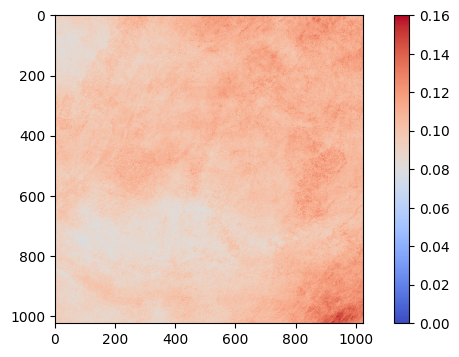

[array(0.10149504, dtype=float32), array(0.10089214, dtype=float32), array(0.10059588, dtype=float32), array(0.10098578, dtype=float32), array(0.1029807, dtype=float32), array(0.10415586, dtype=float32)]


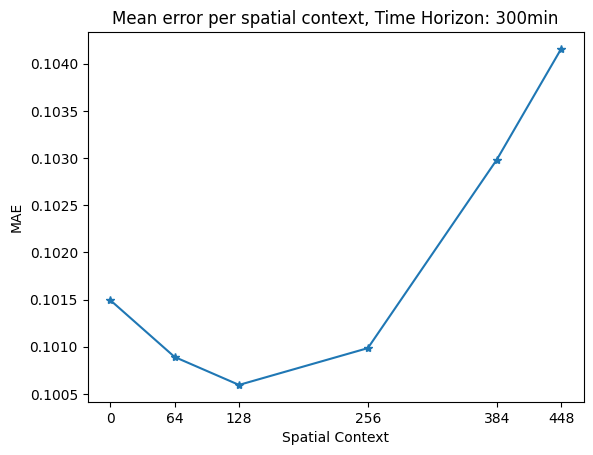

In [11]:
print(f"min- max errors: {error_img_300.min()} - {error_img_300.max()}")

viz.show_image_w_colorbar(
    image=error_img_300.cpu().numpy()[0, 0],
    title=None,
    fig_name="Error Map",
    save_fig=False,
    bar_max=0.16,
    colormap="coolwarm"
)


# mean error against spatial context

spatial_context = [0, 64, 128, 256, 384, 448]
error_per_sc_300 = []
for sc in spatial_context:
    if sc != 0:
        cropped_error_map = error_img_300[0, 0, sc: -sc]
    else:
        cropped_error_map = error_img_300[0, 0]
    error_per_sc_300.append(torch.mean(cropped_error_map).cpu().numpy())

print(error_per_sc_300)

fig, ax = plt.subplots()
plt.plot(spatial_context, error_per_sc_300, "*-")
ax.set_title("Mean error per spatial context, Time Horizon: 300min")
ax.set_ylabel("MAE")
ax.set_xlabel("Spatial Context")
ax.set_xticks(spatial_context)
ax.set_xticklabels(spatial_context)
plt.show()


In [12]:
# improvement with 256 spatial context
improvement_300 = (error_per_sc_300[0] - error_per_sc_300[3])/error_per_sc_300[0] * 100
print(f"Improvement: {improvement_300:.2f}%")


Improvement: 0.50%
